In [144]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [145]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("../Resources/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [146]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

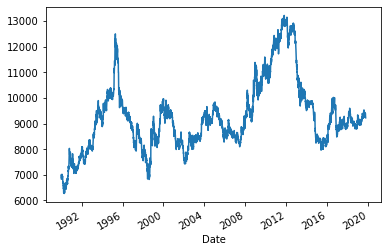

In [147]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot()

# 1.

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [148]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [149]:
settle_noise.head()

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
Name: Settle_cycle, dtype: float64

In [150]:
settle_trend.head()

Date
1990-01-02    6908.503967
1990-01-03    6908.799756
1990-01-04    6909.057104
1990-01-05    6909.223948
1990-01-08    6909.310062
Name: Settle_trend, dtype: float64

In [170]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
settle = yen_futures[['Settle']].copy()
settle['Noise'] = settle_noise
settle['Trend'] = settle_trend
settle.tail()

,Settle,Noise,Trend
Date,,,
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594
2019-10-14,9265.0,-36.423060,9301.423060
2019-10-15,9221.5,-75.844123,9297.344123


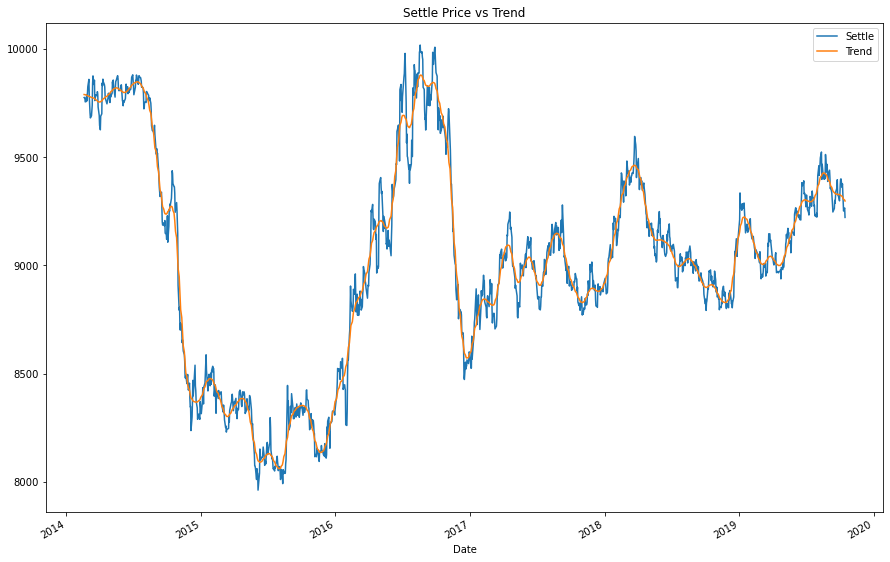

In [171]:
# Plot the Settle Price vs. the Trend for 2015 to the present
settle.plot(y=['Settle', 'Trend'],figsize=[15,10],title='Settle Price vs Trend',legend=True)

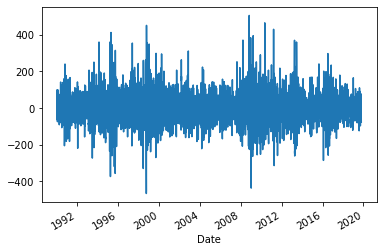

In [172]:
# Plot the Settle Noise
settle_noise.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [123]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Return'] = yen_futures.Settle.pct_change() * 100
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


In [109]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))

model = ARMA(yen_futures.Return.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [108]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1415
Model:                     ARMA(2, 1)   Log Likelihood               -1148.679
Method:                       css-mle   S.D. of innovations              0.545
Date:                Thu, 19 Nov 2020   AIC                           2307.359
Time:                        12:02:01   BIC                           2333.633
Sample:                             0   HQIC                          2317.175
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.015     -0.195      0.845      -0.033       0.027
ar.L1.y        0.3023      0.332      0.911      0.362      -0.348       0.952
ar.L2.y        0.0471      0.027      1.775      0.076      -0.005       0.099
ma.L1.y       -0.3155      0.331     -0.952      0.341      -0.965       0.334
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4059           +0.0000j            2.4059            0.0000
AR.2           -8.8199           +0.0000j            8.8199            0.5000
MA.1            3.1697           +0.0000j            3.1697            0.0000
-----------------------------------------------------------------------------
"""

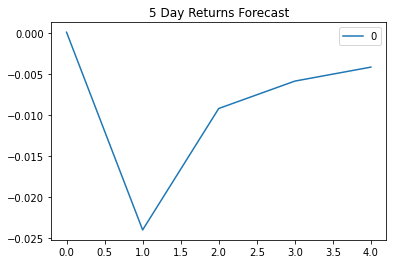

In [110]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [91]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(yen_futures.Settle.values, order=(5, 1, 1))

# Fit the model
arima_results = arima_model.fit()

In [92]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 19 Nov 2020   AIC                          83905.238
Time:                        00:14:28   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3158      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.y      0.2814      0.699      0.402      0.688      -1.090       1.652
ar.L2.D.y      0.0007      0.016      0.042      0.966      -0.030       0.032
ar.L3.D.y     -0.0127      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.890      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.066      0.948      -0.036       0.034
ma.L1.D.y     -0.2964      0.699     -0.424      0.672      -1.667       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8905           -1.3790j            2.3400           -0.1003
AR.2            1.8905           +1.3790j            2.3400            0.1003
AR.3           -2.2637           -3.0253j            3.7785           -0.3522
AR.4           -2.2637           +3.0253j            3.7785            0.3522
AR.5          -10.8643           -0.0000j           10.8643           -0.5000
MA.1            3.3740           +0.0000j            3.3740            0.0000
-----------------------------------------------------------------------------
"""

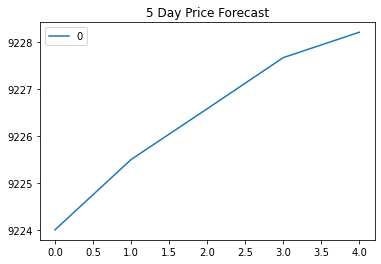

In [93]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [156]:
import arch as arch
from arch import arch_model

In [158]:
yen_futures['Return'] = yen_futures.Settle.pct_change() * 100
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()

In [159]:
# Estimate a GARCH model:
garch_model = arch_model(yen_futures.Return, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
garch_results = garch_model.fit(disp="off")

In [160]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1069.92
Distribution:                  Normal   AIC:                           2147.84
Method:            Maximum Likelihood   BIC:                           2168.86
                                        No. Observations:                 1415
Date:                Thu, Nov 19 2020   Df Residuals:                     1411
Time:                        12:11:55   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3861e-03  1.940e-03      1.230      0.219 [-1.417e-03,6.189e-03]
alpha[1]       0.0403  3.456e-02      1.166      0.244   [-2.744e-02,  0.108]
alpha[2]   1.7715e-09  4.536e-02  3.906e-08      1.000 [-8.890e-02,8.890e-02]
beta[1]        0.9526  2.424e-02     39.291      0.000      [  0.905,  1.000]
=============================================================================

Covariance estimator: robust
"""

In [161]:
# Find the last day of the dataset
last_day = yen_futures.Return.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [163]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [164]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,6.8863,6.905342,6.924196,6.942865,6.961351


In [165]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,6.886300
h.2,6.905342
h.3,6.924196
h.4,6.942865
h.5,6.961351


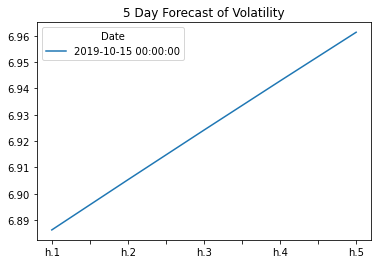

In [166]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

In [ ]:
# 1. Based on my analysis I would buy the yen now.
# 2. The upward trend in the forecast tells me the risk is expected to increase.
# 3. 